<a href="https://colab.research.google.com/github/p172913/Auto-Trading-Bot/blob/main/TradingBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
apikey = 'ENTERYOURAPIKEY'
apisecret = 'ENTERYOURSECRETKEY'

In [93]:
!pip install python-binance pandas mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import pandas
import sqlalchemy
from binance.client import Client
from binance import BinanceSocketManager

In [95]:
client=Client(apikey,apisecret)

In [96]:
bsm=BinanceSocketManager(client)

In [97]:
socket=bsm.trade_socket('BTCUSDT')

In [98]:
await socket.__aenter__()
msg=await socket.recv()
print(msg)

{'e': 'trade', 'E': 1666088126619, 's': 'BTCUSDT', 't': 1986686731, 'p': '19534.26000000', 'q': '0.00237000', 'b': 14492772063, 'a': 14492772097, 'T': 1666088126619, 'm': True, 'M': True}


In [99]:
def create(msg):
  dataframe=pandas.DataFrame([msg])
  dataframe=dataframe.loc[:,['s','E','p']]
  dataframe.columns=['symbols','Time','Price']
  dataframe.Price=dataframe.Price.astype(float)
  dataframe.Time=pandas.to_datetime(dataframe.Time,unit='ms')
  return dataframe

In [100]:
create(msg)

,symbols,Time,Price
0,BTCUSDT,2022-10-18 10:15:26.619,19534.26


In [101]:
engine=sqlalchemy.create_engine('sqlite:///BTCUSDTstream.db')

In [102]:
dataframe = pandas.read_sql('BTCUSDT', engine)

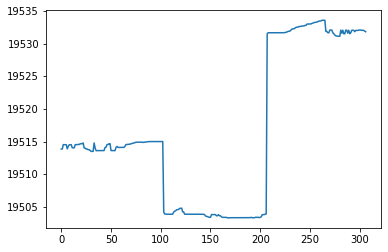

In [103]:
dataframe.Price.plot()

In [ ]:
from sqlalchemy.util import symbol
def helper(entry, lookback, qty ,open_position=False):
  while True:
    dataframe = pandas.read_sql('BTCUSDT', engine)
    lookbackperiod=dataframe.iloc[-lookback:]
    cumret=(lookbackperiod.Price.pct_change()+1).cumprod() -1
    if not open_position:
      if cumret[cumret.last_valid_index()]>entry:
        order=Client.create_order(symbol='BTCUSDT',side='BUY',type='MARKET',quantity=qty)
        print(order)
        open_position=True
        break
  if open_position:
    dataframe = pandas.read_sql('BTCUSDT', engine)
    sincebuy=dataframe.iloc[dataframe.Time>pandas.todatetime(order['transactTime'],unit='ms')
    if len(sincebuy)>1:
      buyret=(sincebuy.Price.pct_change()+1).cumprod() -1
      lastentry=buyret[buyret.last_valid_index()]
      if lastentry>0.0015 or lastentry<-0.0015:
        order=Client.create_order(symbol='BTCUSDT',side='SELL',type='MARKET',quantity=qty)
        print(order)
        break